In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from google3.util.operations_research.cloud.lattle.experiments import mdp

# Speed test


In [ ]:
nums_parcels = [10, 20, 50, 100, 200, 500]
num_trials = 5
no_prune_times = np.zeros((len(nums_parcels), num_trials))
no_prune_iterations = np.zeros((len(nums_parcels), num_trials))
just_pp_times = np.zeros((len(nums_parcels), num_trials))
just_pp_iterations = np.zeros((len(nums_parcels), num_trials))
just_cs_times = np.zeros((len(nums_parcels), num_trials))
just_cs_iterations = np.zeros((len(nums_parcels), num_trials))
prune_times = np.zeros((len(nums_parcels), num_trials))
prune_iterations = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=min(max(timesteps//4, 1), 5),
        num_parcels=num_parcels,
        mean_route_length=min(max(timesteps//2, 1), 10),
        cut_capacities=1,
        unit_weights=True,
        unit_capacities=True,
    )
    init_state, _ = env.reset(rng)

    # With pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    prune_times[i, j] = time.time() - start
    prune_iterations[i, j] = iterations

    # Just parcel pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    just_pp_times[i, j] = time.time() - start
    just_pp_iterations[i, j] = iterations

    # Just step pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state)

    just_cs_times[i, j] = time.time() - start
    just_cs_iterations[i, j] = iterations

    # Without pruning.
    start = time.time()
    state = init_state
    iterations = 0
    while True:
      iterations += 1
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, prune_parcel=False)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, _ = env.step(parcel, truck, state, prune=False)

    no_prune_times[i, j] = time.time() - start
    no_prune_iterations[i, j] = iterations

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

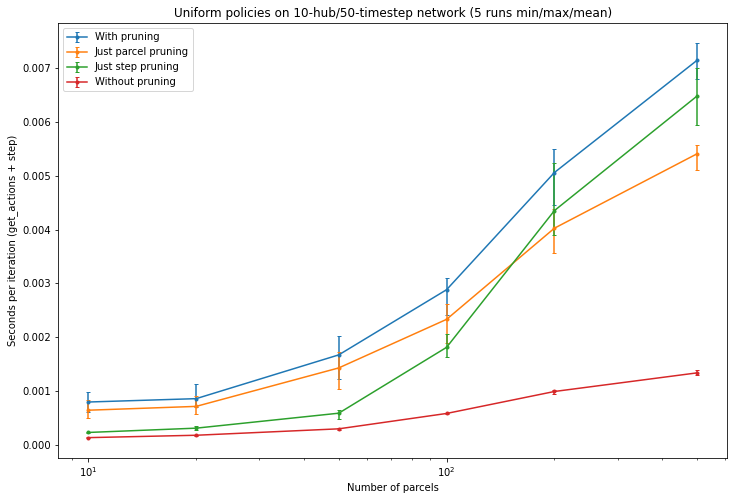

In [ ]:
# Plot performances.
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Uniform policies on 10-hub/50-timestep network (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel("Seconds per iteration (get_actions + step)")
ax.set_xscale('log')
prune_times[prune_times == 0] = np.nan
just_pp_times[just_pp_times == 0] = np.nan
just_cs_times[just_cs_times == 0] = np.nan
no_prune_times[no_prune_times == 0] = np.nan
prune_times_ = prune_times / prune_iterations
just_pp_times_ = just_pp_times / just_pp_iterations
just_cs_times_ = just_cs_times / just_cs_iterations
no_prune_times_ = no_prune_times / no_prune_iterations
ax.errorbar(nums_parcels, np.nanmean(prune_times_, 1), np.stack([np.nanmean(prune_times_, 1) - np.nanmin(prune_times_, 1), np.nanmax(prune_times_, 1) - np.nanmean(prune_times_, 1)]), fmt='.-', capsize=2, label='With pruning')
ax.errorbar(nums_parcels, np.nanmean(just_pp_times_, 1), np.stack([np.nanmean(just_pp_times_, 1) - np.nanmin(just_pp_times_, 1), np.nanmax(just_pp_times_, 1) - np.nanmean(just_pp_times_, 1)]), fmt='.-', capsize=2, label='Just parcel pruning')
ax.errorbar(nums_parcels, np.nanmean(just_cs_times_, 1), np.stack([np.nanmean(just_cs_times_, 1) - np.nanmin(just_cs_times_, 1), np.nanmax(just_cs_times_, 1) - np.nanmean(just_cs_times_, 1)]), fmt='.-', capsize=2, label='Just step pruning')
ax.errorbar(nums_parcels, np.nanmean(no_prune_times_, 1), np.stack([np.nanmean(no_prune_times_, 1) - np.nanmin(no_prune_times_, 1), np.nanmax(no_prune_times_, 1) - np.nanmean(no_prune_times_, 1)]), fmt='.-', capsize=2, label='Without pruning')
ax.legend()

# Routing schemes comparison

In [9]:
# One-step vs. all-step vs. last-parcel routing (all with pruning).
nums_parcels = [10, 20, 50, 100, 200, 500]
num_trials = 5
one_perf = np.zeros((len(nums_parcels), num_trials))
all_perf = np.zeros((len(nums_parcels), num_trials))
last_perf = np.zeros((len(nums_parcels), num_trials))

rng = np.random.default_rng(42)
for i, num_parcels in enumerate(tqdm(nums_parcels)):
  for j in tqdm(range(num_trials), leave=False):
    num_hubs = 10  # Number of depots in the network.
    timesteps = 50  # Number of time steps.
    num_trucks_per_step = num_hubs

    # Create middle-mile environment and initialize state.
    env = mdp.MiddleMileMDP(
        num_hubs=num_hubs,
        timesteps=timesteps,
        num_trucks_per_step=num_trucks_per_step,
        max_truck_duration=min(max(timesteps//4, 1), 5),
        num_parcels=num_parcels,
        mean_route_length=min(max(timesteps//2, 1), 10),
        # cut_capacities=1,
        unit_weights=True,
        unit_capacities=True,
    )
    initial_state, _ = env.reset(rng)

    # One-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state, prune=False)
      deliveries += delivery

    # Record performance.
    one_perf[i, j] = deliveries / num_parcels

    # All-step rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel.
      state, parcel, _ = env.get_next_parcel(state)
      if parcel is None:
        break

      # Route parcel.
      while parcel is not None:
        state, parcel, trucks = env.get_actions(state, parcel)

        # Put parcel onto random truck, get next state.
        truck = rng.choice(trucks)
        state, delivery, parcel = env.step(parcel, truck, state)
        deliveries += delivery

    # Record performance.
    all_perf[i, j] = deliveries / num_parcels

    # Last-parcel rollout with random policy.
    state = initial_state
    deliveries = 0
    while True:
      # Get next parcel and available trucks.
      state, parcel, trucks = env.get_actions(state, last_parcel=True)
      if parcel is None:
        break

      # Put parcel onto random truck, get next state.
      truck = rng.choice(trucks)
      state, delivery, parcel = env.step(parcel, truck, state)
      deliveries += delivery

    # Record performance.
    last_perf[i, j] = deliveries / num_parcels

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

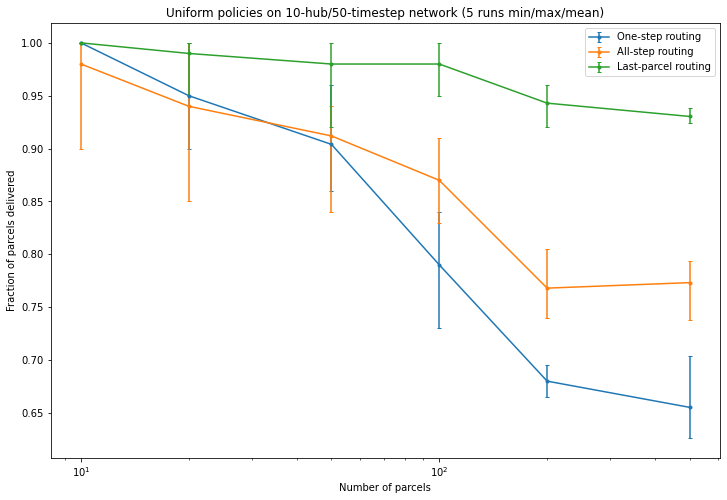

In [10]:
# Plot performances.
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Uniform policies on 10-hub/50-timestep network (5 runs min/max/mean)")
ax.set_xlabel("Number of parcels")
ax.set_ylabel("Fraction of parcels delivered")
ax.set_xscale('log')
one_perf[one_perf == 0] = np.nan
all_perf[all_perf == 0] = np.nan
last_perf[last_perf == 0] = np.nan
ax.errorbar(nums_parcels, np.nanmean(one_perf, 1), np.stack([np.nanmean(one_perf, 1) - np.nanmin(one_perf, 1), np.nanmax(one_perf, 1) - np.nanmean(one_perf, 1)]), fmt='.-', capsize=2, label='One-step routing')
ax.errorbar(nums_parcels, np.nanmean(all_perf, 1), np.stack([np.nanmean(all_perf, 1) - np.nanmin(all_perf, 1), np.nanmax(all_perf, 1) - np.nanmean(all_perf, 1)]), fmt='.-', capsize=2, label='All-step routing')
ax.errorbar(nums_parcels, np.nanmean(last_perf, 1), np.stack([np.nanmean(last_perf, 1) - np.nanmin(last_perf, 1), np.nanmax(last_perf, 1) - np.nanmean(last_perf, 1)]), fmt='.-', capsize=2, label='Last-parcel routing')
ax.legend()